In [1]:
# # These should already be installed on your workspace
# !pip install --disable-pip-version-check --quiet -U langchain==0.2.16
# !pip install --disable-pip-version-check --quiet -U langchain_openai==0.1.23
# !pip install --disable-pip-version-check --quiet -U langgraph==0.2.19
# !pip install --disable-pip-version-check --quiet -U langchainhub==0.1.21
# !pip install --disable-pip-version-check --quiet -U tavily-python==0.4.0
# !pip install --disable-pip-version-check --quiet -U langchain-community==0.2.16
# !pip install --disable-pip-version-check --quiet -U python-dotenv==1.0.1

In [2]:
# Load in the OpenAI key and Tavily key.
# In the project folder, create a file named 'config.env'
# ensure your .env file contains keys named OPENAI_API_KEY="your key" and TAVILY_API_KEY="your key"
from dotenv import load_dotenv
import os

load_dotenv('config.env')
assert os.getenv('OPENAI_API_KEY') is not None
assert os.getenv('TAVILY_API_KEY') is not None

In [3]:
import os
import time
import requests
from pprint import pprint
from typing import Dict, List, Literal

from langgraph.graph import START, END, StateGraph
from langgraph.graph.state import CompiledStateGraph
from langgraph.graph.message import MessagesState, add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langchain_openai import ChatOpenAI

from IPython.display import Image, display
from tavily import TavilyClient

## Instantiate Chat Model

In [4]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
    streaming=True,
    api_key=os.getenv('OPENAI_API_KEY')
)

In [5]:
tavily_client = TavilyClient(
    api_key=os.getenv("TAVILY_API_KEY"),
)

## Define State

In [6]:
class State(MessagesState):
    patient_question: str
    answer: str
    summary: str
    quiz_requested: str = "NO"
    quiz_question: str
    quiz_response: str
    graded_result: str
    new_topic_requested: str = "NO"

## Create Helper Functions

In [7]:
def display_text_to_user(text: str, timer: int = 2):
    pprint(text)
    print()
    time.sleep(timer) # wait for it to render before asking for input or it'll never show up.

In [8]:
def display_messages(messages: MessagesState, timer: int = 2):
    for message in messages:
        message.pretty_print()
    print()
    time.sleep(timer) # wait for it to render before asking for input or it'll never show up.

In [9]:
def ask_user_for_input(input_description: str, timer: int = 2):
    response = input(input_description)
    print()
    time.sleep(timer)
    return response

In [10]:
def reset_state(state: State):
    for key in state.keys():
        state[key] = None

## Define Tools

In [11]:
@tool
def web_search(question:str)->Dict:
    """
    Return top search results for a given search query
    """
    response = tavily_client.search(question)
    return response

In [12]:
tools = [web_search]
tools_by_name = {tool.name: tool for tool in tools}

In [13]:
llm_with_tools = llm.bind_tools(tools)

## Define Nodes and Routers

In [14]:
# tool node:
def web_search_node(state: State):
    messages = state["messages"]

    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        content = str(observation['results'])
        tool_call_id = tool_call["id"]
        messages.append(ToolMessage(content=content, tool_call_id=tool_call_id))

    return {"messages": messages}

In [15]:
# agent nodes:
def entry_point(state: State):
    text = "Hello. How are you doing today?"
    display_text_to_user(text, timer=1)

    system_message = SystemMessage("You are an experienced medical professional. "
                                   "You conduct a web search to respond to a users question.")
    messages = [system_message]
    return {"messages": messages}


def ask_health_topic(state: State):
    messages = state["messages"]

    input_description = "What is your health-related question? Please type a question on a health topic or a medical treatment. "
    human_input = ask_user_for_input(input_description, timer=5)
    
    human_message = HumanMessage(
                    "Perform a web search to answer the following question: "
                    f"```{human_input}```"
                    "Use the appropriate tool and conduct the web research for this question. "
                    "Return a detailed response including health topic, medical condition, treatment options, post-treatment care, "
                    "and important citations from the medical literature or medical news outlets."
                    )
    messages.append(human_message)
    return {"messages": messages, "patient_question": human_input}


def perform_websearch(state: State):
    messages = state["messages"]

    ai_message = llm_with_tools.invoke(messages)
    messages.append(ai_message)
    return {"messages": messages, "answer": ai_message.content}


def summarize_search(state: State):
    answer = state["answer"]
    messages = state["messages"]

    template = ChatPromptTemplate.from_messages(
    [
    ("system", "You are an excellent medical writer who can summarize complex medical topics \n"
               "into easy to understand language that a layman, i.e. somebody who is not a medical expert, can understand \n"
               "so they can make appropriate decisions for their health with the information provided by you."),
    ("human", "Create a concise summary of the provided {answer} for patients \n"
              "that are not medical experts. \n"
              "Create nicely formatted, easily readable text as output \n"
              "with several sections with the headers 'health topic', 'medical condition', 'treatment options', 'post-treatment care' and 'citations'. \n"
              "'health topic': a short description of health topic being discussed, \n"
              "'medical condition': a description of the medical condition, \n"
              "'treatment options': a brief discussion of several treatment options, \n"
              "'post-treatment care': a listing of recommended patient activities during post-treatment care, \n"
              "'citations': include relevant citations from the literature and important medical news outlets if appropriate. \n"
    ),
    ]
    )

    chain = template | llm_with_tools 

    ai_message = chain.invoke({"answer": answer})
    messages.append(ai_message)
    return {"messages": messages, "summary": ai_message.content}


def present_summary(state: State):
    display_text_to_user(state["summary"], timer=10)
    return {"messages": state["messages"]}


def check_quiz_request(state: State):
    input_description = "Do you want to check your comprehension based on a generated quiz? (YES or NO)"
    human_input = ask_user_for_input(input_description, timer=5)
    return {"quiz_requested": human_input}


def create_quiz(state: State):
    summary = state["summary"]
    messages = state["messages"]

    template = ChatPromptTemplate.from_messages(
    [
    ("system", "You are an experienced medical educator and experienced in the creation of medical exams."),
    ("human", "Generate a single, relevant quiz question based on the provided information {summary} ."
              "Create a quiz question that expects a comprehensive answer in 3 to 4 sentences as a response. "
              "Create a quiz question that tests knowledge and understanding of "
              "a medical condition, a treatment option, or of a post-treatment care. "
              "Do not create a multiple-choice quiz. Do not show the solution. "
    ),
    ]
    )

    chain = template | llm 

    ai_message = chain.invoke({"summary": summary})
    messages.append(ai_message)

    quiz_question = ai_message.content
    
    text= ("Please answer following quiz question on the health topic. "
           "Please answer in about 3 to 4 sentences in a comprehensive "
           "response to the question. "
           "Please type your answer in the box provided and hit RETURN: ")

    display_text_to_user(text, timer=2)

#     quiz_question = state["quiz_question"]
    human_input = ask_user_for_input(quiz_question, timer=5)
    return {"messages": messages, "quiz_question": ai_message.content, "quiz_response": human_input}


# def present_quiz(state: State):
#     text= ("Please answer following quiz question on the health topic. "
#            "Please answer in about 3 to 4 sentences in a comprehensive "
#            "response to the question. "
#            "Please type your answer in the box provided and hit RETURN: ")
#     display_text_to_user(text, timer=2)

#     quiz_question = state["quiz_question"]
#     human_input = ask_user_for_input(quiz_question, timer=5)
#     return {"quiz_response": human_input}

    
def grade_quiz(state: State):    
    quiz_response = state["quiz_response"]
    quiz_question = state["quiz_question"]
    summary = state["summary"]
    messages = state["messages"]

    template = ChatPromptTemplate.from_messages(
    [
    ("system", "You are an expert educator with medical expertise tasked with grading a students answer to a quiz question.."),
    ("human",    '''Generate a solution to the quiz question {quiz_question} from the summary {summary}.
                    Use 2 to 3 sentences for your answer. 
                    Evaluate the students response {quiz_response} carefully and assign a letter grade (A, B, C, D, or F)
                    along with a detailed explanation.

                    ## Input Format
                    - **Question:** [The original quiz question] {quiz_question}
                    - **Summary:** [Summary on the health topic] {summary}
                    - **AI Solution:** [The LLMs solution generated from the summary]
                    - **Students Response:** [The students submitted answer] {quiz_response}

                    ## Grading Criteria

                    Evaluate based on the following dimensions:

                    1. **Accuracy (40%)** - Is the information factually correct?
                    2. **Completeness (30%)** - Does it address all parts of the question?
                    3. **Understanding (20%)** - Does it demonstrate comprehension of underlying concepts?
                    4. **Clarity (10%)** - Is it well-organized and clearly communicated?

                    ## Grading Scale

                    - **A (90-100%):** Exceptional. Accurate, complete, demonstrates deep understanding, well-articulated.
                    - **B (80-89%):** Good. Mostly accurate and complete with minor gaps or unclear points.
                    - **C (70-79%):** Satisfactory. Basic understanding but missing key elements or contains some errors.
                    - **D (60-69%):** Poor. Significant gaps, multiple errors, or fundamental misunderstandings.
                    - **F (<60%):** Failing. Incorrect, incomplete, or demonstrates lack of understanding.

                    ## Output Format

                    **Grade:** [Letter Grade]

                    **Explanation:**
                    - **Strengths:** [What the student did well]
                    - **Weaknesses:** [What was missing, incorrect, or unclear]
                    - **Key Missing Elements:** [Specific points from the expected answer that were omitted]
                    - **Suggestions for Improvement:** [Constructive feedback]

                    **Overall Assessment:** [3 to 4 sentence summary justifying the grade]

                    ## Steps:
                    - Generate a solution for the quiz question {quiz_question} based on the information 
                    provided in the summary {summary} in 2 to 3 sentences.
                    Print your solution and title it with AI solution.
                    - List the students answer titled with Students answer.
                    - Then show the grade for the students response {quiz_response} to the question {quiz_question}
                    titled with Grade and an explanation for your grading titled with Explanation of grading.
                    - Be fair, constructive, and specific in your evaluation. Focus on helping the student understand
                    where they succeeded and where they can improve.
                    - Include relevant citations of the {summary} at the end of the explanation.'''),
     ]
     )

    chain = template | llm

    ai_message = chain.invoke({
        "quiz_response": quiz_response,
        "quiz_question": quiz_question,
        "summary": summary,
    }
    )
    messages.append(ai_message)
    return {"messages": messages, "graded_result": ai_message.content}


def present_grade(state: State):  
    display_text_to_user("Here is your graded result: ", timer=1)
    display_text_to_user(state["graded_result"], timer=10)


def check_new_topic(state: State):
    input_description = "Do you want to ask another question about another health-related topic? (YES or NO):"
    human_input = ask_user_for_input(input_description, timer=5)
    return {"new_topic_requested": human_input}

In [16]:
# router functions:
def tool_router(state: MessagesState):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "web_search"
    return END


def check_quiz_request_router(state: State):
    quiz_requested = state["quiz_requested"]
    if quiz_requested.lower() == "yes":
        return "create_quiz"
    return END


def check_new_topic_router(state: State):
    new_topic_requested = state["new_topic_requested"]
    if new_topic_requested.lower() == "yes":
        reset_state(state)
        return "ask_health_topic"
    return END

## Create Workflow 

In [17]:
# workflow = StateGraph(State)
workflow = CompiledStateGraph(State)

In [18]:
workflow.add_node("entry_point", entry_point)
workflow.add_node("ask_health_topic", ask_health_topic)
workflow.add_node("perform_websearch", perform_websearch)
workflow.add_node("web_search", web_search_node)
workflow.add_node("summarize_search", summarize_search)
workflow.add_node("present_summary", present_summary)
workflow.add_node("check_quiz_request", check_quiz_request)
workflow.add_node("create_quiz", create_quiz)
workflow.add_node("grade_quiz", grade_quiz)
workflow.add_node("present_grade", present_grade)
workflow.add_node("check_new_topic", check_new_topic)

In [19]:
workflow.add_edge(START, "entry_point")
workflow.add_edge("entry_point", "ask_health_topic")
workflow.add_edge("ask_health_topic", "perform_websearch")

workflow.add_conditional_edges(
    source="perform_websearch",
    path=tool_router,
    path_map=["web_search", END]
)

workflow.add_edge("web_search", "perform_websearch")
workflow.add_edge("perform_websearch", "summarize_search")
workflow.add_edge("summarize_search", "present_summary")
workflow.add_edge("present_summary", "check_quiz_request")

workflow.add_conditional_edges(
    source="check_quiz_request",
    path=check_quiz_request_router,
    path_map=["create_quiz", END]
)

workflow.add_edge("create_quiz", "grade_quiz")

workflow.add_edge("grade_quiz", "present_grade")
workflow.add_edge("present_grade", "check_new_topic")

workflow.add_conditional_edges(
    source="check_new_topic",
    path=check_new_topic_router,
    path_map=["ask_health_topic", END]
)

## Display Workflow and Add Memory Management

In [20]:
memory = MemorySaver()
graph = workflow.compile(
#             interrupt_before=[   
#                 "web_search",
#             ],
#             interrupt_after=[
#                 "ask_health_topic", 
#                 "perform_websearch",
#                 "summarize_search",
#                 "present_summary",
#                 "check_quiz_request", 
#                 "create_quiz",
#                 "grade_quiz",
#                 "check_new_topic",
#             ], 
            checkpointer=memory,
        )

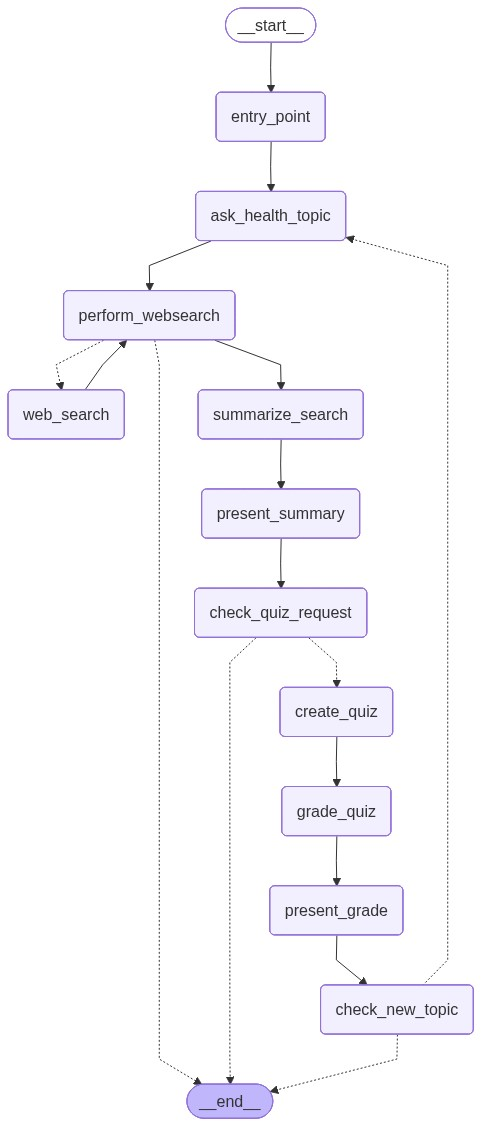

In [21]:
display(Image(graph.get_graph().draw_mermaid_png()))

## Run Initial Workflow

### Possible questions:

#### What are treatment methods for skin melanoma?

#### How do you protect yourself against the flu in the winter season?

In [22]:
config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": 1})

In [23]:
input_question = {"patient_question": ""}

In [24]:
# Ask patient to enter their health-related question:
output = graph.invoke(
    input=input_question,
    config=config,
)

'Hello. How are you doing today?'

What is your health-related question? Please type a question on a health topic or a medical treatment. What are treatment methods for skin melanoma?

('Sure! Please provide the specific health topic or medical condition you '
 "would like me to summarize, and I'll create the formatted text for you.")

Do you want to check your comprehension based on a generated quiz? (YES or NO)YES

('# Health Topic: Skin Melanoma\n'
 '\n'
 'Skin melanoma is a serious type of skin cancer that arises from melanocytes, '
 'the cells responsible for producing the pigment melanin. It is particularly '
 'dangerous because it can spread to other parts of the body if not detected '
 'and treated early.\n'
 '\n'
 '## Medical Condition: Melanoma\n'
 '\n'
 'Melanoma is a form of skin cancer that develops from melanocytes. It is '
 'known for its aggressive nature and potential to metastasize, meaning it can '
 'spread to other organs if not caught in its early stages. Early det

Do you want to check your comprehension based on a generated quiz? (YES or NO)NO



In [25]:
output = graph.invoke(
    input=None,
    config=config,
)

In [26]:
output = graph.invoke(
    input=None,
    config=config,
)

In [27]:
output = graph.invoke(
    input=None,
    config=config,
)

In [28]:
output = graph.invoke(
    input=None,
    config=config,
)

In [29]:
# Ask whether patient wants to do a quiz:
output = graph.invoke(
    input=None,
    config=config,
)

In [30]:
output = graph.invoke(
    input=None,
    config=config,
)

In [31]:
# Ask patient to enter their response to quiz question:
output = graph.invoke(
    input=None,
    config=config,
)

In [32]:
output = graph.invoke(
    input=None,
    config=config,
)

In [33]:
output["patient_question"]

'How do I protect myself against the flu in the winter season?'

In [34]:
output["answer"]

"### Health Topic: Influenza (Flu) Prevention\n\n#### Medical Condition: Influenza (Flu)\nInfluenza, commonly known as the flu, is a contagious respiratory illness caused by influenza viruses. It can cause mild to severe illness and can lead to hospitalization and even death, particularly in high-risk populations such as the elderly, young children, and individuals with certain health conditions.\n\n#### How to Protect Yourself Against the Flu in the Winter Season\n\n1. **Get Vaccinated**:\n   - The most effective way to protect yourself from the flu is to get a flu shot each year. Vaccination helps your body develop immunity against the virus and reduces the risk of severe illness.\n\n2. **Practice Good Hygiene**:\n   - **Hand Washing**: Wash your hands frequently with soap and water for at least 20 seconds, especially after being in public places. If soap and water are not available, use an alcohol-based hand sanitizer.\n   - **Avoid Touching Your Face**: Try to avoid touching your e

In [35]:
output["summary"]

"# Health Topic: Influenza (Flu) Prevention\n\n## Medical Condition\nInfluenza, commonly known as the flu, is a contagious respiratory illness caused by influenza viruses. It can range from mild to severe and may lead to hospitalization or death, especially in high-risk groups such as the elderly, young children, and individuals with certain health conditions.\n\n## Treatment Options\n1. **Vaccination**: The most effective way to prevent the flu is by getting a flu shot annually. This helps your body build immunity against the virus and lowers the risk of severe illness.\n   \n2. **Antiviral Medications**: For those at high risk of flu complications, healthcare providers may recommend antiviral medications to prevent the flu or reduce its severity if contracted.\n\n## Post-Treatment Care\nIf you contract the flu, consider the following activities for recovery:\n- **Rest**: Ensure you get plenty of rest to help your body heal.\n- **Stay Hydrated**: Drink fluids to maintain hydration.\n-

In [36]:
output["quiz_requested"]

'NO'

In [37]:
if output["quiz_requested"] == "yes":
    print(output["quiz_question"])
    print(output["quiz_response"])
    print(output["graded_result"])
    print(output["new_topic_requested"])

In [38]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an experienced medical professional. You conduct a web search to respond to a users question.
================================ Human Message =================================

Perform a web search to answer the following question: ```What are treatment methods for skin melanoma?```Use the appropriate tool and conduct the web research for this question. Return a detailed response including health topic, medical condition, treatment options, post-treatment care, and important citations from the medical literature or medical news outlets.
================================== Ai Message ==================================
Tool Calls:
  web_search (call_w0xeETdwPFO8DcphEMTfLeR4)
 Call ID: call_w0xeETdwPFO8DcphEMTfLeR4
  Args:
    question: What are treatment methods for skin melanoma?
================================= Tool Message =================================

[{'url': 'https://www.mskcc.org/cancer-c

In [39]:
output

{'messages': [SystemMessage(content='You are an experienced medical professional. You conduct a web search to respond to a users question.', id='42248004-390d-44f8-ba93-75acd053f6c8'),
  HumanMessage(content='Perform a web search to answer the following question: ```What are treatment methods for skin melanoma?```Use the appropriate tool and conduct the web research for this question. Return a detailed response including health topic, medical condition, treatment options, post-treatment care, and important citations from the medical literature or medical news outlets.', id='5932afaa-197c-4308-87bd-84c7e6c51555'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_w0xeETdwPFO8DcphEMTfLeR4', 'function': {'arguments': '{"question":"What are treatment methods for skin melanoma?"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_c4585b5b9c'}, id=

In [40]:
config = RunnableConfig(recursion_limit=2000, configurable={"thread_id": 2})

In [41]:
output = graph.invoke(
    input=input_question,
    config=config,
)

'Hello. How are you doing today?'

What is your health-related question? Please type a question on a health topic or a medical treatment. How do you protect yourself against the flu in the winter season?

('Sure! Please provide the specific health topic or medical condition you '
 "would like me to summarize, and I'll create the formatted text for you.")

Do you want to check your comprehension based on a generated quiz? (YES or NO)YES

('# Health Topic: Influenza Prevention\n'
 '\n'
 'Influenza, commonly known as the flu, is a contagious respiratory illness '
 'that can lead to serious health complications, especially in vulnerable '
 'groups like the elderly, young children, and those with certain health '
 'conditions.\n'
 '\n'
 '## Medical Condition: Influenza (Flu)\n'
 '\n'
 'Influenza is caused by influenza viruses and spreads easily from person to '
 'person. Symptoms can range from mild to severe and may include fever, cough, '
 'sore throat, body aches, and fatigue. It is cruc

In [42]:
for message in output["messages"]:
    message.pretty_print()

================================ System Message ================================

You are an experienced medical professional. You conduct a web search to respond to a users question.
================================ Human Message =================================

Perform a web search to answer the following question: ```How do you protect yourself against the flu in the winter season?```Use the appropriate tool and conduct the web research for this question. Return a detailed response including health topic, medical condition, treatment options, post-treatment care, and important citations from the medical literature or medical news outlets.
================================== Ai Message ==================================
Tool Calls:
  web_search (call_5nACj3l7d4sm1gc4Tx9ZGe8B)
 Call ID: call_5nACj3l7d4sm1gc4Tx9ZGe8B
  Args:
    question: How do you protect yourself against the flu in the winter season?
================================= Tool Message =================================

